In [1]:
# load data and shuffle it
import glob
import cv2
import numpy as np
import pandas as pd
"""
img = cv2.imread(r'data\TrainingData\0003.jpg')
cv2.imshow('0003 test', img)
img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
cv2.imshow('after downsampling', img)
cv2.waitKey()
"""
def bin2class(row):
    if row[0] == False and row[1] == False:
        return 0
    elif row[0] == False and row[1] == True:
        return 1
    elif row[0] == True and row[1] == False:
        return 2
    elif row[0] == True and row[1] == True:
        return 3


#images = [cv2.imread(file) for file in glob.glob(r'data\TrainingData\*.jpg')]
rsize = 128
images = [cv2.resize(cv2.imread(file),(rsize,rsize),interpolation=cv2.INTER_AREA) for file in glob.glob(r'data\TrainingData\*.jpg')]
x = np.array(images, dtype=np.float64) / 255	# x.shape = N, height, width, channel

tags = pd.read_excel(r'data\DataInfo.xlsx', true_values=["'High'", "'MIBC'"], false_values=["'Low'","'NMIBC'"])
tags = tags.iloc[:, 1:].to_numpy(dtype=int) 	# tags.shape = N, grading, staging
y = np.apply_along_axis(bin2class, 1, tags) 	# y.shape = (N, ) one-hot encoding

# shuffle data
N = y.shape[0]
shuffle_mask = np.random.shuffle(np.arange(N))
x[:] = x[shuffle_mask]
y[:] = y[shuffle_mask]

print(x.shape)
print(y.shape)

(478, 128, 128, 3)
(478,)


In [ ]:
"""
======locally connected layers======
    (F, C, H, W)    S next, params
L1: (16, 3, 11, 11) 3 40,   9318400
L2: (16, 16, 9, 9)  1 32,   21250048
L3: (16, 16, 9, 9)  1 24,   11953152
======fully connected layers========
F1: (24*24*16, 300)
F2: (300, 300)
F3: (300, 300)
======output layer==================
F:  (300, 4)
softmax
"""

In [4]:
# overfitting on small set of data
from keras.models import Sequential
from keras import optimizers
from keras.layers import LocallyConnected2D, BatchNormalization
from keras.layers import LeakyReLU, Dense, Dropout, Flatten, Softmax
from keras import regularizers
from keras.utils import to_categorical

num_classes = 4
x_pre, y_pre = x[:30], y[:30]
y_pre = to_categorical(y_pre, num_classes)

model = Sequential()
# N, 3 ,128, 128
model.add(LocallyConnected2D(16, 11, strides=(3, 3), input_shape=(128, 128, 3)))
model.add(BatchNormalization(axis=1))
model.add(LeakyReLU(alpha=0.3))
# N, 16, 40, 40
model.add(LocallyConnected2D(16, 9))
model.add(BatchNormalization(axis=1))
model.add(LeakyReLU(alpha=0.3))
# N, 16, 32, 32
model.add(LocallyConnected2D(16, 9))
model.add(BatchNormalization(axis=1))
model.add(LeakyReLU(alpha=0.3))
# N, 16, 24, 24
model.add(Flatten())
# N, 16*24*24
model.add(Dense(500))
model.add(BatchNormalization(axis=1))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization(axis=1))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))

model.add(Dense(500))
model.add(BatchNormalization(axis=1))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Softmax())

optim = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
hist = model.fit(x_pre, y_pre, batch_size=100, epochs=20, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
30/30 [==============================] - 98s 3s/step - loss: 2.3855 - acc: 0.1333
Epoch 2/20
30/30 [==============================] - 22s 720ms/step - loss: 0.9587 - acc: 0.6667
Epoch 3/20
30/30 [==============================] - 21s 700ms/step - loss: 0.9269 - acc: 0.6667
Epoch 4/20
30/30 [==============================] - 17s 560ms/step - loss: 0.7288 - acc: 0.8000
Epoch 5/20
30/30 [==============================] - 15s 513ms/step - loss: 0.1865 - acc: 0.9333
Epoch 6/20
30/30 [==============================] - 17s 551ms/step - loss: 0.1090 - acc: 0.9667
Epoch 7/20
30/30 [==============================] - 13s 444ms/step - loss: 0.0361 - acc: 1.0000
Epoch 8/20
30/30 [==============================] - 13s 443ms/step - loss: 0.0502 - acc: 1.0000
Epoch 9/20
30/30 [==============================] - 15s 516ms/step - loss: 0.0174 - acc: 1.0000
Epoch 10/20
30/30 [==============================] - 14s 460ms/step - loss: 0.0090 - acc: 1

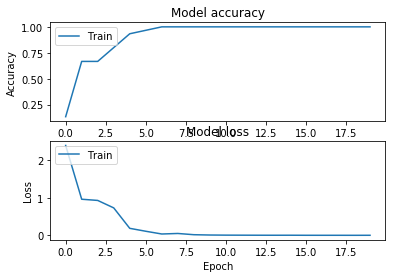

In [6]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
#plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
#plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# split for cross validation
delim = [120, 240, 360]
xs = np.split(x, delim)
ys = np.split(y, delim)

loss, acc = 0, 0
for vali in range(4):
    print("======Cross validation step %d======"%(vali+1))
    x_train = np.vstack([xs[i] for i in range(4) if i != vali])
    x_val = to_categorical(xs[vali], 4)
    y_train = np.hstack([ys[i] for i in range(4) if i!=vali])
    y_val = to_categorical(ys[vali], 4)
    
    # establish model
    model = Sequential()
    model.add()
    
    optim = keras.optimizers.Adam(lr=0.004, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
    # train
    hist = model.fit(x_train, y_train, batch_size=200, epochs=25, validation_data=(x_val, y_val), shuffle=False)
    loss += hist.history['val_acc'][-1]
    acc += hist.history['val_loss'][-1]
    
    